# Seismic inversion using randomized linear algebra

In this notebook we show how to use `TimeProbeSeismic.jl` to compute FWI gradient using a very memory efficient traceestimation algorithm. 
We are highlighting this method on a simple 2D slice of the overthrust model.

In [1]:
using TimeProbeSeismic
import TimeProbeSeismic: qr_data

┌ Info: Precompiling TimeProbeSeismic [cd417b76-fc6b-4228-be91-94f5ea77264b]
└ @ Base loading.jl:1342


In [2]:
~isfile("../data/overthrust/overthrust_model.h5") && run(`curl -L ftp://slim.gatech.edu/data/SoftwareRelease/WaveformInversion.jl/2DFWI/overthrust_model_2D.h5 --create-dirs -o ../data/overthrust/overthrust_model.h5`)
n, d, o, m0, m = h5read("../data/overthrust/overthrust_model.h5", "n", "d", "o", "m0", "m")

([801, 207], [25.0, 25.0], [0.0, 0.0], Float32[0.44444445 0.44444445 … 0.027777797 0.027777793; 0.44444445 0.44444445 … 0.027777797 0.027777793; … ; 0.44444445 0.44444445 … 0.027784508 0.02778376; 0.44444445 0.44444445 … 0.027784498 0.027783753], Float32[0.44444445 0.44444445 … 0.027777778 0.027777778; 0.44444445 0.44444445 … 0.027777778 0.027777778; … ; 0.44444445 0.44444445 … 0.027777778 0.027777778; 0.44444445 0.44444445 … 0.027777778 0.027777778])

In [3]:
n = Tuple(n)
o = Tuple(o)
d = Tuple(d)
m0[:, 20:end] = imfilter(m0[:, 20:end] ,Kernel.gaussian(5))
dm = vec(m - m0)

# Setup info and model structure
nsrc = 2	# number of sources
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0)

Model((801, 207), (25.0, 25.0), (0.0, 0.0), 40, Dict{Symbol, PhysicalParameter{Float32}}(:m => [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445  …  0.027790619, 0.027790515, 0.027790422, 0.027790338, 0.027790265, 0.027790202, 0.027790146, 0.027790101, 0.027790064, 0.027790034]))

In [4]:
# Set up receiver geometry
nxrec = n[1]
xrec = range(0f0, stop=(n[1] - 1)*d[1], length=nxrec)
yrec = 0f0
zrec = range(12.5f0, stop=12.5f0, length=nxrec)


12.5f0:0.0f0:12.5f0

In [5]:
# receiver sampling and recording time
timeD = 3000f0   # receiver recording time [ms]
dtD = 4f0  # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtD, t=timeD, nsrc=nsrc)

GeometryIC{Float32}(Vector{Float32}[[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0  …  19775.0, 19800.0, 19825.0, 19850.0, 19875.0, 19900.0, 19925.0, 19950.0, 19975.0, 20000.0], [0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0  …  19775.0, 19800.0, 19825.0, 19850.0, 19875.0, 19900.0, 19925.0, 19950.0, 19975.0, 20000.0]], Vector{Float32}[[0.0], [0.0]], Vector{Float32}[[12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5  …  12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5], [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5  …  12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5]], Float32[4.0, 4.0], Integer[751, 751], Float32[3000.0, 3000.0])

In [6]:
# Set up source geometry (cell array with source locations for each shot)
xsrc = convertToCell(range(0f0, (n[1] - 1)*d[1]/2, length=nsrc))
ysrc = convertToCell(range(0f0, 0f0, length=nsrc))
zsrc = convertToCell(range(12.5f0, 12.5f0, length=nsrc))
            # Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtD, t=timeD)


GeometryIC{Float32}(Vector{Float32}[[0.0], [10000.0]], Vector{Float32}[[0.0], [0.0]], Vector{Float32}[[12.5], [12.5]], Float32[4.0, 4.0], Integer[751, 751], Float32[3000.0, 3000.0])

In [7]:
# setup wavelet
f0 = 0.010f0     # kHz
wavelet = ricker_wavelet(timeD, dtD, f0)
q = judiVector(srcGeometry, wavelet)


judiVector{Float32, Matrix{Float32}}("Seismic data vector", 1502, 1, 2, GeometryIC{Float32}(Vector{Float32}[[0.0], [10000.0]], Vector{Float32}[[0.0], [0.0]], Vector{Float32}[[12.5], [12.5]], Float32[4.0, 4.0], Integer[751, 751], Float32[3000.0, 3000.0]), Matrix{Float32}[[-0.00096925104; -0.0019277442; … ; -0.0; -0.0], [-0.00096925104; -0.0019277442; … ; -0.0; -0.0]])

# Linear operators

In [8]:
###################################################################################################
# Write shots as segy files to disk
opt = Options(space_order=16)

# Setup operators
F = judiModeling(model, srcGeometry, recGeometry; options=opt)
F0 = judiModeling(model0, srcGeometry, recGeometry; options=opt)
J = judiJacobian(F0, q)

judiJacobian{Float32, Float32}("linearized wave equation", 1203102, 165807, Info(165807, 2, Integer[1899, 1899]), Model((801, 207), (25.0, 25.0), (0.0, 0.0), 40, Dict{Symbol, PhysicalParameter{Float32}}(:m => [0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445  …  0.027790619, 0.027790515, 0.027790422, 0.027790338, 0.027790265, 0.027790202, 0.027790146, 0.027790101, 0.027790064, 0.027790034])), judiVector{Float32, Matrix{Float32}}("Seismic data vector", 1502, 1, 2, GeometryIC{Float32}(Vector{Float32}[[0.0], [10000.0]], Vector{Float32}[[0.0], [0.0]], Vector{Float32}[[12.5], [12.5]], Float32[4.0, 4.0], Integer[751, 751], Float32[3000.0, 3000.0]), Matrix{Float32}[[-0.00096925104; -0.0019277442; … ; -0.0; -0.0], [-0.00096925104; -0.0019277442; … ; -0.0; -0.0]]), GeometryIC{Float32}(Vector{Float32}[[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0  …  19775.0, 19800.0, 19825.0, 19850.0, 19875.0, 19900.0, 1992

In [9]:
# data
# Nonlinear modeling
dobs = F*q
d0 = F0*q
residual = d0 - dobs

judiVector{Float32, Matrix{Float32}}("F*q", 1203102, 1, 2, GeometryIC{Float32}(Vector{Float32}[[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0  …  19775.0, 19800.0, 19825.0, 19850.0, 19875.0, 19900.0, 19925.0, 19950.0, 19975.0, 20000.0], [0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0  …  19775.0, 19800.0, 19825.0, 19850.0, 19875.0, 19900.0, 19925.0, 19950.0, 19975.0, 20000.0]], Vector{Float32}[[0.0], [0.0]], Vector{Float32}[[12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5  …  12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5], [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5  …  12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5]], Float32[4.0, 4.0], Integer[751, 751], Float32[3000.0, 3000.0]), Matrix{Float32}[[1.6178001f-7 1.432722f-7 … 0.0 0.0; 3.0733645f-6 2.9393486f-6 … 0.0 0.0; … ; 0.027677044 0.021337224 … 0.0 0.0; -0.0021659469 -0.0021806473 … 0.0 0.0], [-6.310663f-29 -1.7250545f-28 … -1.3085869f-31 -2.660

# Probing vectors
We show waht the probing vectors look like in this case and how close to the identity their outer product is.

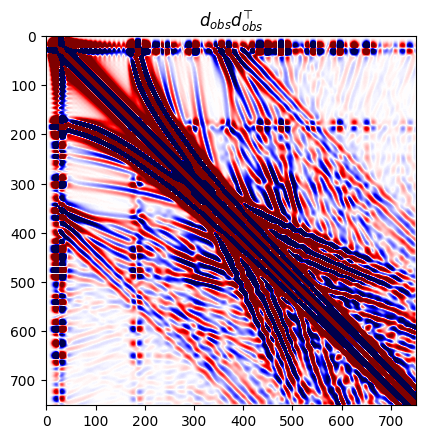

PyObject Text(0.5, 1.0, '$d_{obs} d_{obs}^\\top$')

In [10]:
# Probing vectors
figure();imshow(dobs.data[1]*dobs.data[1]', cmap="seismic", vmin=-10, vmax=10)
title(L"$d_{obs} d_{obs}^\top$")

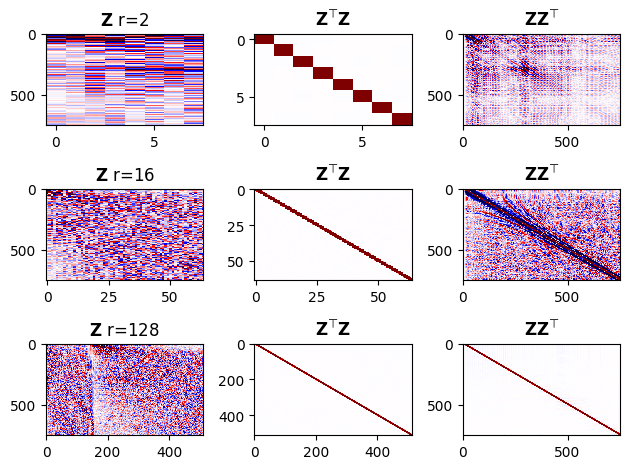

In [11]:

figure()
for r=1:3:7
    subplot(3,3,r)
    Q = qr_data(dobs.data[1], 2^(r+2))
    imshow(Q, vmin=-.1, vmax=.1, cmap="seismic", aspect="auto", interpolation="none")
    title(L"$\mathbf{Z}$ "*"r=$(2^r)")
    subplot(3, 3, r+1)
    imshow(Q'*Q,vmin=-1e-2, vmax=1e-2, cmap="seismic", aspect="auto")
    title(L"$\mathbf{Z}^\top \mathbf{Z}$")
    subplot(3, 3, r+2)
    imshow(Q*Q',vmin=-1e-2, vmax=1e-2, cmap="seismic", aspect="auto")
    title(L"$\mathbf{Z}\mathbf{Z}^\top$")
end
tight_layout()

# FWI gradients

In [12]:
# gradient
g = Array{Any}(undef, 2)
g[1] = J[1]'*residual[1]
g[2] = J[2]'*residual[2];

In [13]:

# Probe
Jp = judiJacobian(F0, q, 2^1, dobs)
ge = Array{Any}(undef, 8, 2)
for r=1:8
    set_r!(Jp, 2^r)
    ge[r, 1] = Jp[1]'*residual[1]
    ge[r, 2] = Jp[2]'*residual[2]
end

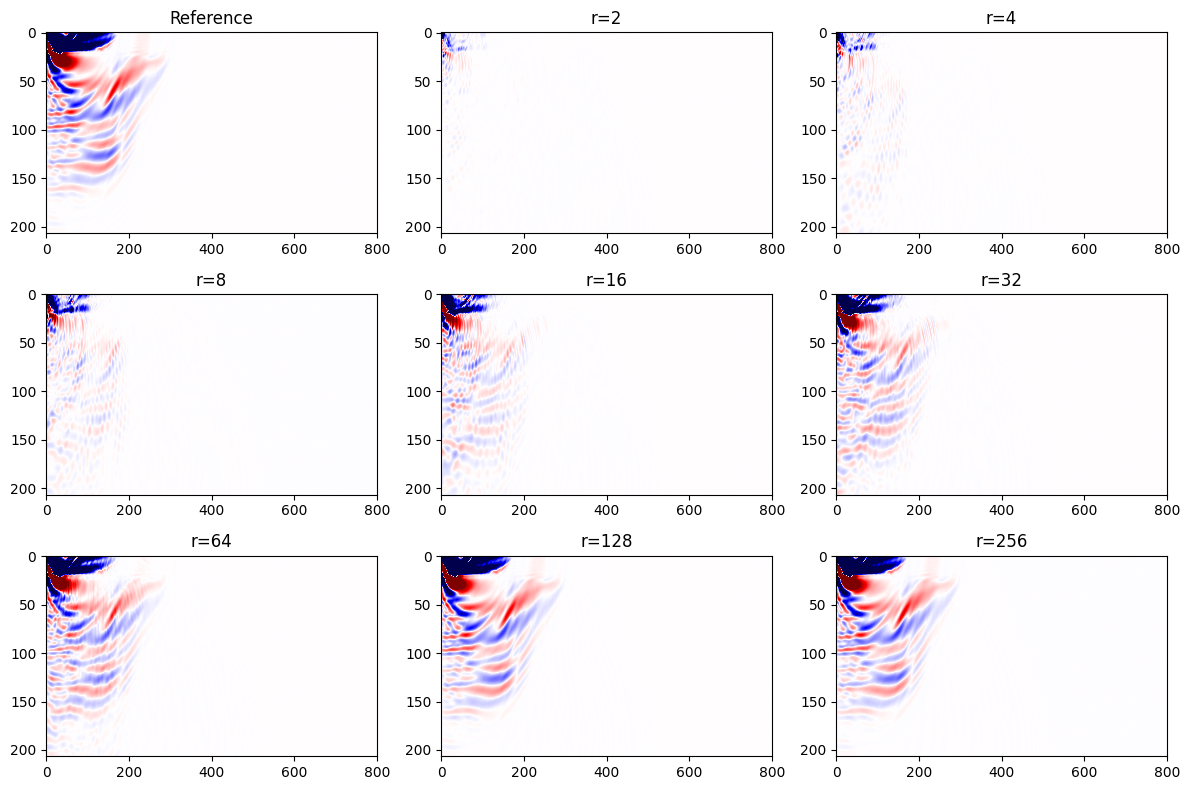

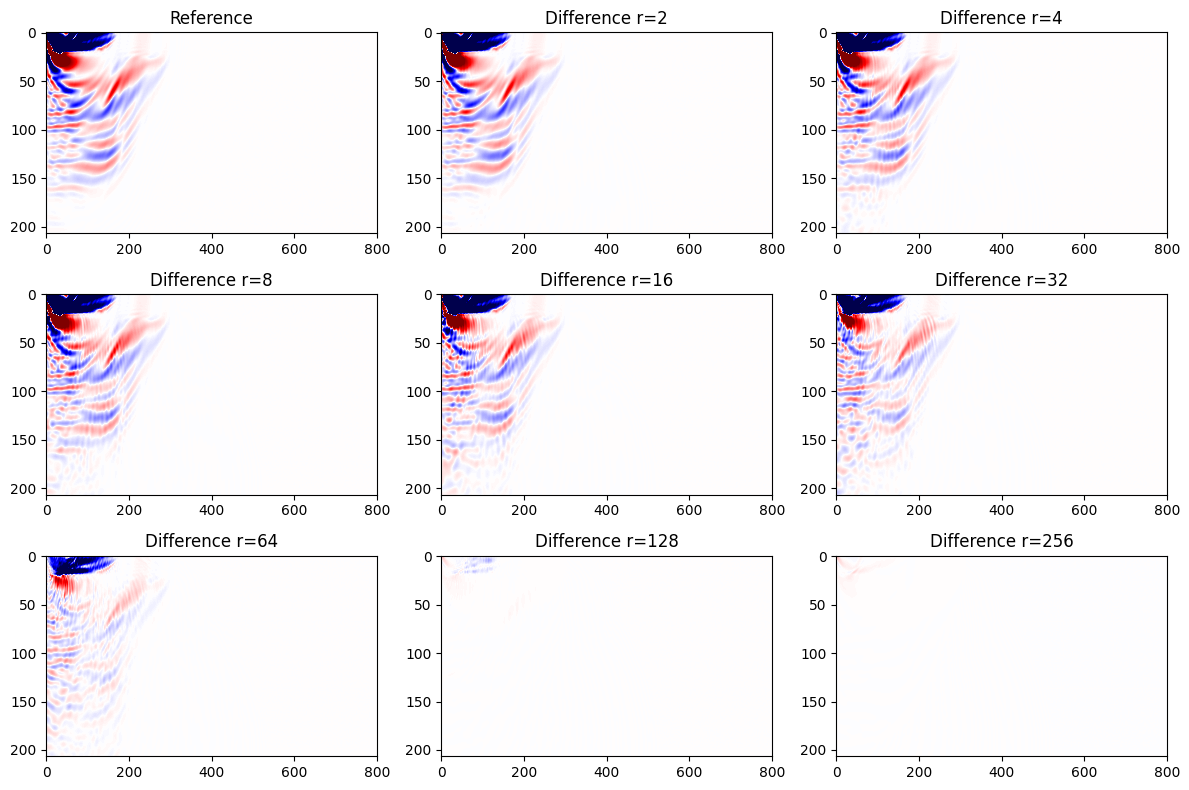

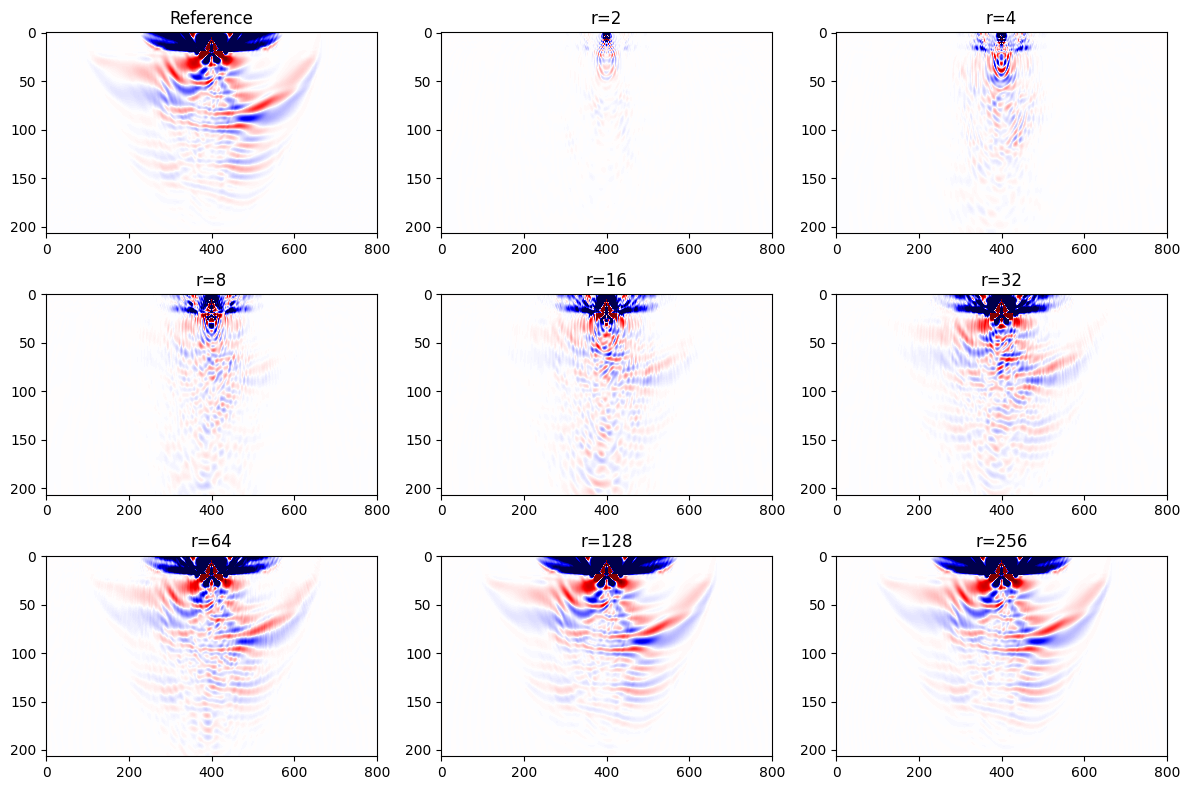

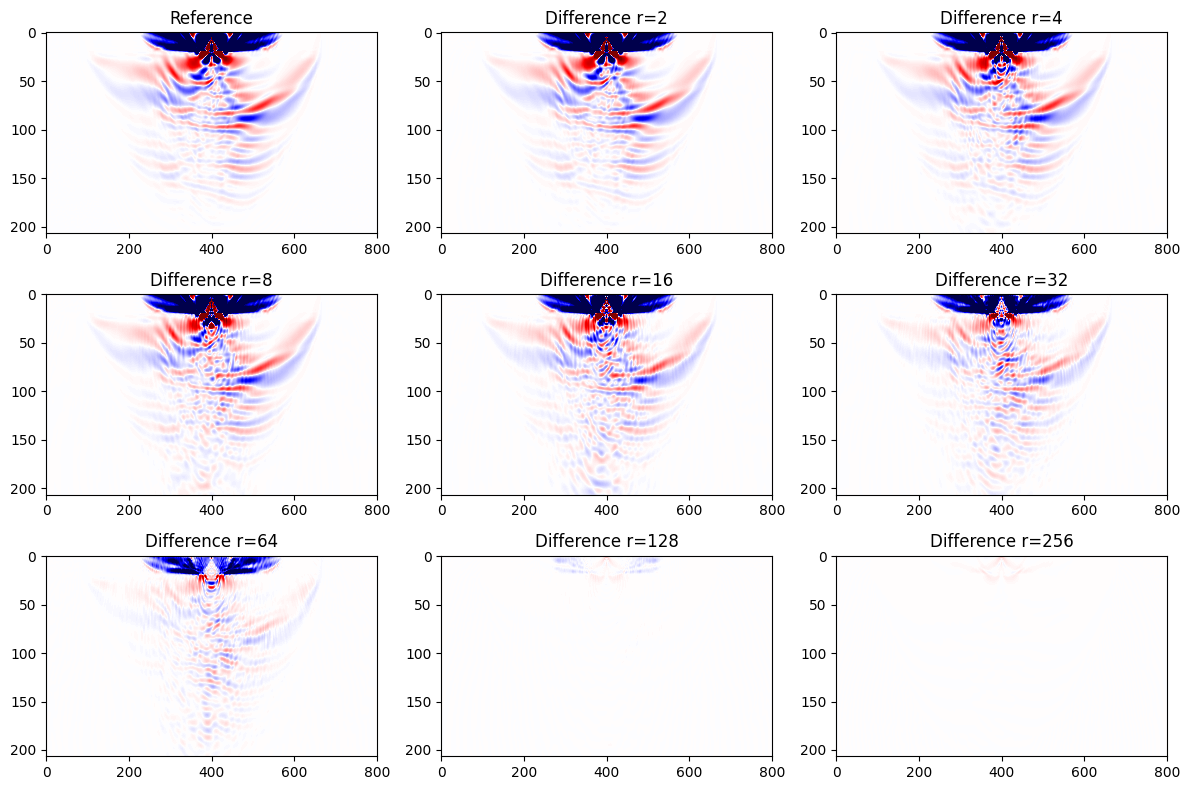

In [14]:

for i=1:2
    clip = maximum(g[i])/10
    figure(figsize=(12, 8))
    subplot(331)
    imshow(g[i]', cmap="seismic", vmin=-clip, vmax=clip, aspect="auto")
    title("Reference")
    for r=1:8
        subplot(3,3,r+1)
        imshow(ge[r, i]', cmap="seismic", vmin=-clip, vmax=clip, aspect="auto")
        title("r=$(2^r)")
    end
    tight_layout()
    figure(figsize=(12, 8))
    subplot(331)
    imshow(g[i]', cmap="seismic", vmin=-clip, vmax=clip, aspect="auto")
    title("Reference")
    for r=1:8
        subplot(3,3,r+1)
        imshow(g[i]' - ge[r,i]', cmap="seismic", vmin=-clip, vmax=clip, aspect="auto")
        title("Difference r=$(2^r)")
    end
    tight_layout()
end


# Check similarities
We consider the similarity $s = \frac{< g, \tilde{g}>}{||g||||\tilde{g}||}$ that computes how aligned twho vetors are irrespective of their amplitude. This is in practice all ythat matters for inversion since the linesearch can absorb any scaling difference.

In [15]:
# Similarities
similar = [simil(g[1], ge[i, 1]) for i=1:8]
similar2 = [simil(g[2], ge[i, 2]) for i=1:8]
# Similarities with muted wated
mw(x::PhysicalParameter) = mw(x.data)
mw(x::Array) = x[:, 19:end]
similar1 = [simil(mw(g[1]), mw(ge[i, 1])) for i=1:8]
similar12 = [simil(mw(g[2]), mw(ge[i, 2])) for i=1:8]


8-element Vector{Float32}:
 0.10399548
 0.28411928
 0.521993
 0.8163789
 0.9452895
 0.98823494
 0.9999682
 0.99998295

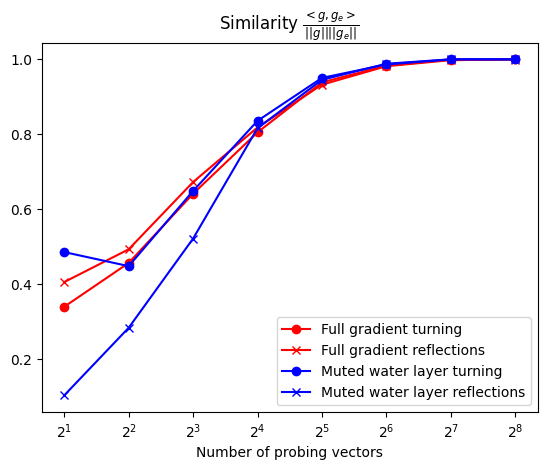

PyObject <matplotlib.legend.Legend object at 0x7f0e83198fd0>

In [19]:

figure()
semilogx([2^i for i=1:8], similar, "-or", label="Full gradient turning", basex=2)
semilogx([2^i for i=1:8], similar2, "-xr", label="Full gradient reflections", basex=2)
semilogx([2^i for i=1:8], similar1, "-ob", label="Muted water layer turning", basex=2)
semilogx([2^i for i=1:8], similar12, "-xb", label="Muted water layer reflections", basex=2)
title(L"Similarity $\frac{<g, g_e>}{||g|| ||g_e||}$")
xlabel("Number of probing vectors")
legend()

# Adjoint test
We now check how close to the true Jacobian addjoitn our estimate is since iterative solvers such as `lsqr` macy behave poorly if the adjoint is too far off

In [20]:
# Adjoint test
at = Array{Any}(undef, 8, 2)
δd = J*dm
J0 = dot(δd, residual)
for i=1:2
    for r=1:8
        at[r, i] = dot(ge[r, i], dm)
        @printf("r=%d,  <J x, y> : %2.5e, <x, J' y> : %2.5e, relative error : %2.5e \n",
                2^r, J0, at[r, i], (J0 - at[r, i])/(J0 + at[r, i]))
    end
end

att1 = [abs(1 - J0/at[i, 1]) for i=1:8]
att2 = [abs(1 - J0/at[i, 2]) for i=1:8];

r=2,  <J x, y> : -6.22874e+05, <x, J' y> : -2.79126e+03, relative error : 9.91077e-01 
r=4,  <J x, y> : -6.22874e+05, <x, J' y> : -4.32573e+03, relative error : 9.86206e-01 
r=8,  <J x, y> : -6.22874e+05, <x, J' y> : -1.75267e+04, relative error : 9.45263e-01 
r=16,  <J x, y> : -6.22874e+05, <x, J' y> : -4.69659e+04, relative error : 8.59770e-01 
r=32,  <J x, y> : -6.22874e+05, <x, J' y> : -9.86907e+04, relative error : 7.26454e-01 
r=64,  <J x, y> : -6.22874e+05, <x, J' y> : -1.46652e+05, relative error : 6.18852e-01 
r=128,  <J x, y> : -6.22874e+05, <x, J' y> : -1.81650e+05, relative error : 5.48429e-01 
r=256,  <J x, y> : -6.22874e+05, <x, J' y> : -1.82318e+05, relative error : 5.47144e-01 
r=2,  <J x, y> : -6.22874e+05, <x, J' y> : -4.37026e+03, relative error : 9.86065e-01 
r=4,  <J x, y> : -6.22874e+05, <x, J' y> : -1.87664e+04, relative error : 9.41505e-01 
r=8,  <J x, y> : -6.22874e+05, <x, J' y> : -5.77967e+04, relative error : 8.30177e-01 
r=16,  <J x, y> : -6.22874e+05, <x, 

8-element Vector{Float32}:
 141.52567
  32.19088
   9.776982
   4.3866754
   1.5937076
   0.6673142
   0.43635583
   0.43292487

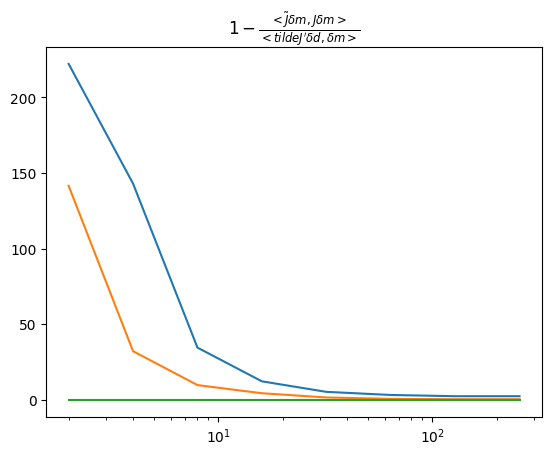

PyObject Text(0.5, 1.0121527777777775, "$1 - \\frac{<\\tilde{J} \\delta m, J \\delta m>}{<tilde{J}' \\delta d, \\delta m>}$")

In [22]:
figure()
semilogx([2^i for i=1:8], att1, basex=2, label="Probed adjoint test")
semilogx([2^i for i=1:8], att2, basex=2, label="Probed adjoint test reflections")
semilogx([2^i for i=1:8], [0 for i=1:8], label="target")
title(L"$1 - \frac{<\tilde{J} \delta m, J \delta m>}{<tilde{J}' \delta d, \delta m>}$")